In [1]:
pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys
import os
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")
    sys.path.append(module_path+"\\References")


import data_preprocessing as dp
import metrics
from neural_network import NeuralNetwork
from ga_neural_network import GeneticAlgorithm

In [4]:
import tensorflow_addons as tfa

In [5]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [7]:
data = pd.read_excel('/content/final_data.xlsx')
data.head()

,Unnamed: 0,Team size**1 x Actual duration**1,Dedicated team members**1 x Actual duration**1,Actual duration**1 x Development environment adequacy**1 x 11-20**1,Team size**1 x 21-30**1 x Inaccurate requirements specifications and required the re-analysis of the software requirements**1,User resistance**1 x Project manager**1 x 21-30**1,Development environment adequacy**1 x 21-30**1 x Inaccurate requirements specifications and required the re-analysis of the software requirements**1,Actual duration**1 x 21-30**1 x Inaccurate requirements specifications and required the re-analysis of the software requirements**1,Requirment stability**1 x 21-30**1 x Inaccurate requirements specifications and required the re-analysis of the software requirements**1,Dedicated team members**1 x Technical stability**1 x Tool availability**1,...,Dedicated team members**1 x Actual duration**1 x Economic instability impact**1,Technical stability**1 x 21-30**1 x Accurate requirements specifications used to develop the software system**1,Dedicated team members**1 x Actual duration**1 x Accurate requirements specifications used to develop the software system**1,Dedicated team members**1 x Users stability**1 x 1-5**1,Object points**1 x Project manager**1 x >500**1,Team size**1 x Developer**1 x >500**1,Dedicated team members**1 x Users stability**1 x Accurate requirements specifications used to develop the software system**1,Dedicated team members**1 x Team cohesion**1 x Developer incentives policy**1,Requirment stability**1 x Tool availability**1 x 11-20**1,Actual effort
0,0,18.0,18.0,0,0,0.0,0,0,0.0,42,...,18.0,0,18.0,0.0,0,6,11.333333,96,0.000000,3168.0
1,1,9.0,9.0,0,0,0.0,0,0,0.0,24,...,27.0,0,0.0,0.0,0,0,0.000000,108,0.000000,1584.0
2,2,30.0,30.0,0,0,0.0,0,0,0.0,48,...,60.0,0,0.0,0.0,0,0,0.000000,180,0.000000,5280.0
3,3,36.0,24.0,6,0,0.0,0,0,0.0,32,...,24.0,0,24.0,0.0,0,0,20.000000,16,10.031746,5280.0
4,4,216.0,216.0,24,0,0.0,0,0,0.0,36,...,648.0,0,216.0,0.0,0,0,17.000000,54,18.603175,38016.0


In [8]:
target = data['Actual effort']
X = data.drop(['Unnamed: 0', 'Actual effort'], axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, random_state = 24)
X_train, X_test = pd.DataFrame(X_train, columns = X.columns), pd.DataFrame(X_test, columns = X.columns)
scaler, X_train = dp.scaling_numerical_data(X_train.columns, X_train)
X_test = scaler.transform(X_test)

In [10]:
y_scaler = StandardScaler()
y_train_sc = y_scaler.fit_transform(y_train.to_numpy().reshape((-1, 1))) 
y_test_sc = y_scaler.fit_transform(y_test.to_numpy().reshape((-1, 1))) 

In [31]:
with tf.device(device_name):
  neuralNetwork = NeuralNetwork({'learning_rate': 0.01, 'momentum': 0.1, 'Dropout': 0.01, 'batch_size': 32}, X_train, y_train, 3000, 10)
  scores = neuralNetwork.cv_scores(metrics)
  time.time()

In [33]:
print('5k fold cross validation r2 score {}, std {}'.format(scores['r2'].mean(), scores['r2'].std()))
print('5k fold cross validation mean absolute error {}, std {}'.format(scores['mae'].mean(), scores['mae'].std()))
print('5k fold cross validation mean magnitude of relative error {}, std {}'.format(scores['mmre'].mean(), scores['mmre'].std()))
print('5k fold cross validation pred of 25% {}, std {}'.format(scores['pred'].mean(), scores['pred'].std()))

5k fold cross validation r2 score 0.9792344164538322, std 0.035027082688558794
5k fold cross validation mean absolute error 570.223310546875, std 478.1654800886633
5k fold cross validation mean magnitude of relative error 2.855058564422535, std 0.6667048314579468
5k fold cross validation pred of 25% 0.8126315789473685, std 0.08510055971119045


In [34]:
neuralNetwork.fit()
train_predictions = neuralNetwork.predict(X_train)
test_predictions = neuralNetwork.predict(X_test)

1/1 [==============================] - 0s 119ms/step


In [35]:
metrics.scores_DataFrame(y_train, y_test, train_predictions.reshape((train_predictions.shape[0],)), test_predictions.reshape((test_predictions.shape[0],)))

,Train score,Test score
r2_score,0.992034,0.997812
MAE,478.003438,589.632731
MMRE,0.198939,0.140538
PRED (0.25),0.864583,0.833333


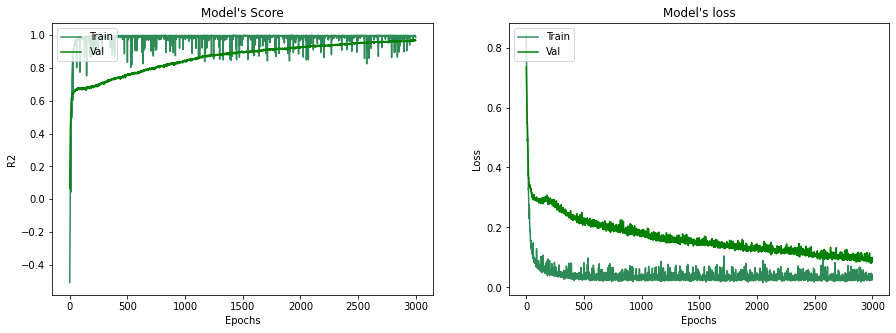

In [38]:
neuralNetwork.plot_history()

# Genetic algortihms

In [13]:
parameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0.001, 0.01, 0.1],
    'Dropout': [0, 0.01, 0.1, 0.2, 0.5],
    'batch_size': [10, 11, 12, 15]
}

In [14]:
optimizer = GeneticAlgorithm(parameters, X_train, y_train, 6, 0.999, 270, 0.01, 2)

In [15]:
best_params = optimizer.evolution()

In [42]:
best_params[0]

{'learning_rate': 0.01, 'momentum': 0.1, 'Dropout': 0.01, 'batch_size': 10}

In [43]:
with tf.device(device_name):
  neuralNetwork = NeuralNetwork(best_params[0], X_train, y_train, 3000, 10)
  scores = neuralNetwork.cv_scores(metrics)
  time.time()

In [44]:
print('5k fold cross validation r2 score {}, std {}'.format(scores['r2'].mean(), scores['r2'].std()))
print('5k fold cross validation mean absolute error {}, std {}'.format(scores['mae'].mean(), scores['mae'].std()))
print('5k fold cross validation mean magnitude of relative error {}, std {}'.format(scores['mmre'].mean(), scores['mmre'].std()))
print('5k fold cross validation pred of 25% {}, std {}'.format(scores['pred'].mean(), scores['pred'].std()))

5k fold cross validation r2 score 0.9848647162070522, std 0.016853019000177737
5k fold cross validation mean absolute error 662.461599763569, std 360.61972546432395
5k fold cross validation mean magnitude of relative error 2.895281550308847, std 0.6567255175592287
5k fold cross validation pred of 25% 0.791578947368421, std 0.05780854828524626


In [45]:
neuralNetwork.fit()
train_predictions = neuralNetwork.predict(X_train)
test_predictions = neuralNetwork.predict(X_test)

1/1 [==============================] - 0s 160ms/step


In [46]:
metrics.scores_DataFrame(y_train, y_test, train_predictions.reshape((train_predictions.shape[0],)), test_predictions.reshape((test_predictions.shape[0],)))

,Train score,Test score
r2_score,0.998072,0.998921
MAE,351.868856,362.726339
MMRE,0.132551,0.086567
PRED (0.25),0.84375,0.875


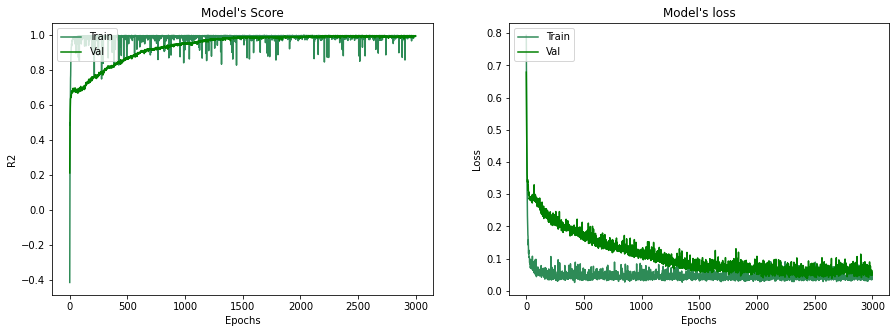

In [47]:
neuralNetwork.plot_history()

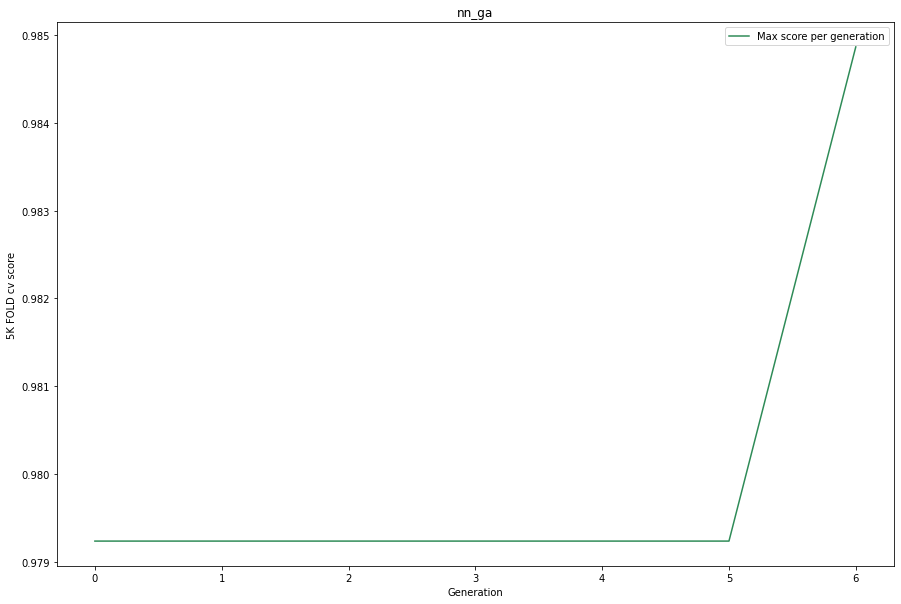

In [48]:
optimizer.plot_generations_scores('nn_ga')

In [59]:
tf.keras.utils.plot_model(NeuralNetwork(best_params[0], X_train, y_train, 3000, 10).create_network(), to_file='/content/final_nn_model.pdf')